# e10s-addons-beta49-week1: Main analysis

(This covers data from 2016-08-03 to 2016-08-13 on Beta 49)

## Data processing

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import plotly.plotly as py
import IPython
import pyspark.sql.functions as fun
from pyspark.sql import Row

from __future__ import division
from moztelemetry.spark import get_pings, get_one_ping_per_client, get_pings_properties
from montecarlino import grouped_permutation_test

%pylab inline
IPython.core.pylabtools.figsize(16, 7)

/home/hadoop/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Unable to parse whitelist (/home/hadoop/anaconda2/lib/python2.7/site-packages/moztelemetry/histogram-whitelists.json). Assuming all histograms are acceptable.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.defaultParallelism

128

In [92]:
def chi2_distance(xs, ys, eps = 1e-10, normalize = True):
    """ The comparison metric for histograms. """
    histA = xs.sum(axis=0)
    histB = ys.sum(axis=0)
    
    if normalize:
        histA = histA/histA.sum()
        histB = histB/histB.sum()
    
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    return d

def median_diff(xs, ys):
    return np.median(xs) - np.median(ys)

def make_group_histogram(group_data):
    """ Combine separate client histograms into a single group histogram, normalizing bin counts
        to relative frequencies.       
    """
    ## Check for histograms with 0 counts.
    client_totals = group_data.map(lambda x: x.sum())
    group_data = group_data[client_totals > 0]
    ## Convert frequency counts to relative frequency for each client histogram.
    group_data = group_data.map(lambda x: x/x.sum())
    ## Merge the group's client histograms by adding up the frequencies over all clients
    ## in the group, separately for each bin.
    group_data = group_data.sum()
    ## Convert the merged bin frequencies to relative percentages.
    group_data = 100 * group_data / group_data.sum()
    return group_data
    

def compare_histogram(histogram, e10s_addons, none10s_addons, e10s_std=None, none10s_std=None,
                      include_diff=True, include_diff_in_diff=True):
    """ Compare an e10s histogram to a non-e10s one, and graph the results.
        
        Plots the two histograms overlaid on the same graph, and prints a p-value
        for testing whether they are different. If 'include_diff' is True, also
        draw a plot of the frequency differences for each bin.
        
        If 'include_diff_in_diff' is True and data is supplied, include a plot of
        differences between addon cohort differences and non-addon cohort differences.
    """
    eTotal = make_group_histogram(e10s_addons)
    nTotal = make_group_histogram(none10s_addons)
    
    if include_diff:
        fig, (ax, diff_ax) = plt.subplots(2, sharex=True)
    else:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(hspace=0.3)
    
    ax2 = ax.twinx()
    width = 0.4
    ylim = max(eTotal.max(), nTotal.max())
        
    eTotal.plot(kind="bar", alpha=0.5, color="green", label="e10s", ax=ax, width=width,
                position=0, ylim=(0, ylim + 1))
    nTotal.plot(kind="bar", alpha=0.5, color="blue", label="non-e10s", ax=ax2, width=width,
                position=1, grid=False, ylim=ax.get_ylim())
    
    ## Combine legend info from both Axes.
    ax_h, ax_l = ax.get_legend_handles_labels()
    ax2_h, ax2_l = ax2.get_legend_handles_labels()
    ax.legend(ax_h + ax2_h, ax_l + ax2_l, loc = 0)
 
    plt.title(histogram)
    ax.set_ylabel("Frequency %")
    
    if include_diff:
        ## Add a second barplot of the difference in frequency for each bucket.
        #diff_ax = fig.add_subplot(2, 1, 2)
        enDiff = eTotal - nTotal
        
        has_diff_in_diff_data = (e10s_std is not None and len(e10s_std) > 0 and
                                 none10s_std is not None and len(none10s_std) > 0)
        if include_diff_in_diff and has_diff_in_diff_data:
            ## Add bin differences for between e10s/non-e10s for the no-addons cohorts.
            ## The assumption is that the difference between addons cohorts would look the same
            ## if there is no additional effect of having addons.
            eTotal_std = make_group_histogram(e10s_std)
            nTotal_std = make_group_histogram(none10s_std)
            enDiff_std = eTotal_std - nTotal_std
            ylims = (min(enDiff.min(), enDiff_std.min()) - 0.5, max(enDiff.max(), enDiff_std.max()) + 0.5)
            diff_ax2 = diff_ax.twinx()
            
            enDiff.plot(kind="bar", alpha=0.5, color="navy", label="with add-ons", ax=diff_ax, width=width,
                        position=1, ylim=ylims)
            enDiff_std.plot(kind="bar", alpha=0.5, color="white", label="no add-ons", ax=diff_ax2, width=width,
                        position=0, grid=False, ylim=diff_ax.get_ylim())

            ## Combine legend info from both Axes.
            diff_ax_h, diff_ax_l = diff_ax.get_legend_handles_labels()
            diff_ax2_h, diff_ax2_l = diff_ax2.get_legend_handles_labels()
            leg_h = diff_ax_h + diff_ax2_h
            leg_l = diff_ax_l + diff_ax2_l
            
        else:
            if include_diff_in_diff:
                ## We wanted to do the additional comparison, but there wasn't enough data.
                print("\nNo diff-in-diff comparison: one of the standard cohorts has no non-missing observations.")
            enDiff.plot(kind="bar", alpha=0.5, color="navy", label="with add-ons", ax=diff_ax)
            leg_h, leg_l = diff_ax.get_legend_handles_labels()
        
        plt.title("e10s/non-e10s difference (more e10s in bucket when > 0)")
        diff_ax.set_ylabel("Diff in frequency %")
        diff_ax.legend(leg_h, leg_l, loc = 0)
    
    
    # Only display at most 100 tick labels on the x axis.
    xticklabs = plt.gca().get_xticklabels()
    max_x_ticks = 100
    if len(xticklabs) > max_x_ticks:
        step_size = math.ceil(float(len(xticklabs)) / max_x_ticks)
        for i, tl in enumerate(xticklabs):
            if i % step_size != 0:
                tl.set_visible(False)
    
    plt.show()
    
    ## Compute a p-value for the chi-square distance between the groups' combined histograms.
    pvalue = grouped_permutation_test(chi2_distance, [e10s_addons, none10s_addons], num_samples=100)
    print("The probability that the distributions for {} (with add-ons) are differing by chance is {:.3f}."\
          .format(histogram, pvalue))

def normalize_uptime_hour(frame):
    """ Convert metrics to rates per hour of uptime. """
    frame = frame[frame["payload/simpleMeasurements/totalTime"] > 60]
    frame = 60 * 60 * frame.apply(lambda x: x / frame["payload/simpleMeasurements/totalTime"]) # Metric per hour
    frame.drop('payload/simpleMeasurements/totalTime', axis=1, inplace=True)
    return frame
    
def compare_e10s_count_histograms(pings, cohort_sizes = {}, *histogram_names, **kwargs):
    """ Read multiple count histograms from a collection of pings, and compare e10s/non-e10s for each.
    
        Treats count histograms as scalars for comparison purposes, without distinguishing between
        parent and child processes. Expects a dict containing overall cohort sizes
        for computing sample size proportions.
    """
    properties = histogram_names + ("payload/simpleMeasurements/totalTime", "e10s", "addons")
    frame = pd.DataFrame(get_pings_properties(pings, properties).collect())

    e10s = frame[frame["addons"] & frame["e10s"]]
    e10s = normalize_uptime_hour(e10s)
    
    none10s = frame[frame["addons"] & ~frame["e10s"]]
    none10s = normalize_uptime_hour(none10s)
    
    include_diff_in_diff = kwargs.get("include_diff_in_diff", True)
    if include_diff_in_diff:
        e10s_std = normalize_uptime_hour(frame[~frame["addons"] & frame["e10s"]])
        none10s_std = normalize_uptime_hour(frame[~frame["addons"] & ~frame["e10s"]])        
    
    for histogram in histogram_names:
        if histogram not in none10s.columns:
            continue
        
        ## Remove the property path from the histogram name for display purposes.
        hist_name = hist_base_name(histogram)
        ## Print a header for the block of graphs, including a link to the histogram definition.
        print_with_markdown("Comparison for count histogram {} (with add-ons):".format(link_to_histogram(hist_name)))
        
        e10s_hist = e10s[histogram].dropna()
        non_e10s_hist = none10s[histogram].dropna()
        
        ## Print some information on sample sizes.
        print("{} non-e10s profiles have this histogram.".format(
                sample_size_str(len(non_e10s_hist), cohort_sizes.get("addons-set2a-control"))))
        print("{} e10s profiles have this histogram.".format(
                sample_size_str(len(e10s_hist), cohort_sizes.get("addons-set2a-test"))))
        ## If either group has no data, nothing more to do.
        if len(non_e10s_hist) == 0 or len(e10s_hist) == 0:
            continue
        
        print("")
        compare_scalars(hist_name + " per hour", e10s_hist, non_e10s_hist,
                        e10s_std[histogram].dropna() if include_diff_in_diff else None,
                        none10s_std[histogram].dropna() if include_diff_in_diff else None)
 
def compare_e10s_histograms(pings, cohort_sizes = {}, *histogram_names, **kwargs):
    """ Read multiple histograms from a collection of pings, and compare e10s/non-e10s for each.
    
        Outputs separate comparisons for parent process, child processes, and merged histograms.
        Expects a dict containing overall cohort sizes for computing sample
        size proportions.
    """
    ## Load histogram data from the ping set, separating parent & child processes for e10s.
    frame = pd.DataFrame(get_pings_properties(pings, histogram_names + ("e10s", "addons") , with_processes=True)\
        .collect())
    ## The addons experiment cohorts.
    e10s_addons = frame[frame["addons"] & frame["e10s"]]
    none10s_addons = frame[frame["addons"] & ~frame["e10s"]]
    ## The standard experiment cohorts.
    e10s_std = frame[~frame["addons"] & frame["e10s"]]
    none10s_std = frame[~frame["addons"] & ~frame["e10s"]]
    
    for histogram in histogram_names:
        if histogram not in none10s_addons.columns:
            continue
        
        ## Remove the property path from the histogram name for display purposes.
        hist_name = hist_base_name(histogram)
        ## Print a header for the block of graphs, including a link to the histogram definition.
        print_with_markdown("Comparison for {} (with add-ons):".format(link_to_histogram(hist_name)))
        
        ## Compare the main histogram for non-e10s against each of 3 for e10s.
        addons_hist_data = {
            "non_e10s": none10s_addons[histogram],
            "e10s_merged": e10s_addons[histogram],
            "e10s_parent": e10s_addons[histogram + "_parent"],
            "e10s_children": e10s_addons[histogram + "_children"]
        }
        for htype in addons_hist_data:
            addons_hist_data[htype] = addons_hist_data[htype].dropna()
        
        ## Print some information on sample sizes.
        sample_sizes = { htype: len(hdata) for htype, hdata in addons_hist_data.iteritems() }
        print("{} non-e10s profiles have this histogram.".format(
                sample_size_str(sample_sizes["non_e10s"], cohort_sizes.get("addons-set2a-control"))))
        print("{} e10s profiles have this histogram.".format(
                sample_size_str(sample_sizes["e10s_merged"], cohort_sizes.get("addons-set2a-test"))))
        ## If either group has no data, nothing more to do.
        if sample_sizes["non_e10s"] == 0 or sample_sizes["e10s_merged"] == 0:
            continue
        
        print("{} e10s profiles have the parent histogram.".format(
                sample_size_str(sample_sizes["e10s_parent"], cohort_sizes.get("addons-set2a-test"))))
        print("{} e10s profiles have the children histogram.".format(
                sample_size_str(sample_sizes["e10s_children"], cohort_sizes.get("addons-set2a-test"))))
        
        has_parent = sample_sizes["e10s_parent"] > 0
        has_children = sample_sizes["e10s_children"] > 0
        
        non_e10s_std_hist = none10s_std[histogram].dropna()
        
        ## Compare merged histograms, unless e10s group has either no parents or no children.
        if has_children and has_parent:
            compare_histogram(hist_name + " (e10s merged)", 
                              addons_hist_data["e10s_merged"],
                              addons_hist_data["non_e10s"],
                              e10s_std[histogram].dropna(),
                              non_e10s_std_hist,
                              **kwargs)
        
        if has_parent:
            compare_histogram(hist_name + " (parent)",
                              addons_hist_data["e10s_parent"],
                              addons_hist_data["non_e10s"],
                              e10s_std[histogram + "_parent"].dropna(),
                              non_e10s_std_hist,
                              **kwargs)

        if has_children:
            compare_histogram(hist_name + " (children)",
                              addons_hist_data["e10s_children"],
                              addons_hist_data["non_e10s"],
                              e10s_std[histogram + "_children"].dropna(),
                              non_e10s_std_hist,
                              **kwargs)

def compare_scalars(metric, e10s_data, non_e10s_data, e10s_std=None, non_e10s_std=None, unit="units"):
    """ Prints info about the median difference between the groups, together with a p-value
        for testing the difference.
        
        Optionally include a string indicating the units the metric is measured in.
        If data is supplied, also print a comparison for non-addons cohorts.
    """
    e10s_data = e10s_data.dropna()
    non_e10s_data = non_e10s_data.dropna()
    if len(e10s_data) == 0 or len(non_e10s_data) == 0:
        print("Cannot run comparison: one of the groups has no non-missing observations.")
        return
    
    print("Comparison for {}{} (with add-ons):\n".format(metric, " ({})".format(unit) if unit != "units" else ""))
    e10s_median = np.median(e10s_data)
    non_e10s_median = np.median(non_e10s_data)
    mdiff = median_diff(e10s_data, non_e10s_data)
    print("- Median with e10s is {:.3g} {} {} median without e10s."\
         .format(
            #abs(mdiff),
            mdiff,
            unit,
            #"higher than" if mdiff >= 0 else "lower than"
            "different from"))
    print("- This is a relative difference of {:.1f}%.".format(float(mdiff) / non_e10s_median * 100))
    print("- E10s group median is {:.4g}, non-e10s group median is {:.4g}.".format(e10s_median, non_e10s_median))
            
    print("\nThe probability of this difference occurring purely by chance is {:.3f}."\
        .format(grouped_permutation_test(median_diff, [e10s_data, non_e10s_data], num_samples=10000)))
    
    if e10s_std is not None and non_e10s_std is not None:
        ## Include a comparison between non-addon cohorts.
        e10s_std = e10s_std.dropna()
        non_e10s_std = non_e10s_std.dropna()
        if len(e10s_std) > 0 and len(non_e10s_std) > 0:
            non_e10s_std_median = np.median(non_e10s_std)
            mdiff_std = median_diff(e10s_std, non_e10s_std)
            print("\nFor cohorts with no add-ons, median with e10s is {:.3g} {} ({:.1f}%) {} median without"\
                 .format(
                    #abs(mdiff_std),
                    mdiff_std,
                    unit,
                    float(mdiff_std) / non_e10s_std_median * 100,
                    #"higher than" if mdiff_std >= 0 else "lower than"
                    "different from"))

    
def link_to_histogram(hist_name):
    """ Create a link to the histogram definition in Markdown. """
    return "[{}](https://dxr.mozilla.org/mozilla-central/search?q={}+file%3AHistograms.json&redirect=true)"\
            .format(hist_name, hist_name)

def hist_base_name(path_to_histogram):
    """ Remove any path components from histogram name.
    
        If histogram is specified as a path in the payload, with separator '/',
        remove everything but the last component (the actual name).
    """
    return path_to_histogram.rsplit("/")[-1]

## Hack to render links in code output.
from IPython.display import Markdown, display
def print_with_markdown(md_text):
    """ Print Markdown text so that it renders correctly in the cell output. """
    display(Markdown(md_text))

def sample_size_str(sample_size, cohort_size=None):
    """ Convert a sample size to a string representation, including a percentage if available. """
    if sample_size == 0:
        return "No"
    if cohort_size:
        if sample_size == cohort_size:
            return "All"
        return "{} ({:.1f}%)".format(sample_size, float(sample_size) / cohort_size * 100)
    return str(sample_size)

### Get e10s/non-e10s cohorts for the add-ons experiment

The derived dataset is computed from profiles on Beta 49 who have e10sCohort set. It contains a single record (ping) per client, which is randomly selected from among the client's pings during the date range.

In [4]:
dataset = sqlContext.read.parquet("s3://telemetry-parquet/e10s_experiment_view/e10s_addons_beta49_cohorts/v20160803_20160813/")
dataset.printSchema()

root
 |-- clientId: string (nullable = false)
 |-- e10sCohort: string (nullable = false)
 |-- creationTimestamp: string (nullable = false)
 |-- submissionDate: string (nullable = false)
 |-- documentId: string (nullable = false)
 |-- sampleId: integer (nullable = false)
 |-- buildId: string (nullable = false)
 |-- simpleMeasurements: string (nullable = false)
 |-- settings: string (nullable = false)
 |-- addons: string (nullable = false)
 |-- system: string (nullable = false)
 |-- build: string (nullable = false)
 |-- threadHangStats: string (nullable = false)
 |-- histograms: string (nullable = false)
 |-- keyedHistograms: string (nullable = false)
 |-- childPayloads: string (nullable = false)
 |-- processes: string (nullable = false)



How many records are in the overall dataset?

In [5]:
dataset.count()

2326301

What are the cohorts, and how many clients do we have in each cohort?

In [6]:
%time cohort_counts = dataset.groupby("e10sCohort").count().collect()
dataset_count = sum(map(lambda r: r["count"], cohort_counts))

def cohort_proportions(r):
    prop = r["count"] * 100.0 / dataset_count
    return (r["e10sCohort"], r["count"], "{:.2f}%".format(prop))

print("\nTotal number of clients: {}".format(dataset_count))
sorted(map(cohort_proportions, cohort_counts), key = lambda r: r[0])

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 12 s

Total number of clients: 2326301


[(u'addons-set2a-control', 28762, '1.24%'),
 (u'addons-set2a-test', 28890, '1.24%'),
 (u'control', 453473, '19.49%'),
 (u'disqualified', 15, '0.00%'),
 (u'disqualified-control', 679339, '29.20%'),
 (u'disqualified-test', 679175, '29.20%'),
 (u'optedIn', 2794, '0.12%'),
 (u'optedOut', 9893, '0.43%'),
 (u'test', 441768, '18.99%'),
 (u'unknown', 2123, '0.09%'),
 (u'unsupportedChannel', 69, '0.00%')]

Restrict to pings belonging to the e10s add-ons experiment. Also include the standard e10s test/control for comparison.

In [8]:
addons_exp_dataset = dataset.filter(
        "e10sCohort in ('addons-set2a-test', 'addons-set2a-control', 'test', 'control')")

How many clients are left?

In [9]:
addons_exp_dataset.count()

952893

We want to make sure that the pings tagged into the two cohorts satisfy the basic assumptions of the experiment, as this not guaranteed. All pings should have active addons, and e10s should be enabled if and only if the ping belongs to the test cohort.

In [10]:
def e10s_status_check(settings, addons):
    """ Check whether e10s is enabled, and whether there are add-ons. """
    e10sEnabled = json.loads(settings).get("e10sEnabled")
    active_addons = json.loads(addons).get("activeAddons")
    return Row(
        e10s_enabled = bool(e10sEnabled), 
        has_addons = bool(active_addons)
    )

def bad_ping(cohort, settings, addons):
    """ e10s should be enabled iff the profile is in the test cohort, and profiles should have active add-ons
        iff they are in the addons cohorts. 
    """
    check_data = e10s_status_check(settings, addons)
    is_bad = cohort.endswith("test") != check_data.e10s_enabled
    if cohort.startswith("addons"):
        is_bad = is_bad or not check_data.has_addons
    return is_bad

## Add a Column to the DF with the outcome of the check.
## This will be used to remove any bad rows after examining them.
from pyspark.sql.types import BooleanType
status_check_udf = fun.udf(bad_ping, BooleanType())
addons_exp_dataset_check = addons_exp_dataset.withColumn("badPing",
    status_check_udf(addons_exp_dataset.e10sCohort, addons_exp_dataset.settings, addons_exp_dataset.addons))

If there are any bad pings, describe the problems and remove them from the dataset.

In [11]:
addons_exp_dataset_bad = addons_exp_dataset_check.filter(addons_exp_dataset_check.badPing)\
    .select("e10sCohort", "settings", "addons")\
    .rdd

if addons_exp_dataset_bad.isEmpty():
    print("No issues")
else:
    check_counts = addons_exp_dataset_bad\
        .map(lambda r: (r.e10sCohort, e10s_status_check(r.settings, r.addons)))\
        .countByValue()
    print("Issues:")
    for k, v in check_counts.iteritems():
        print("{}: {}".format(k, v))
    print("\nRemoving these pings from the dataset.")
    addons_exp_dataset = addons_exp_dataset_check.filter(~addons_exp_dataset_check.badPing).drop("badPing")
    print("The dataset now contains {} clients".format(addons_exp_dataset.count()))

Issues:
(u'addons-set2a-test', Row(e10s_enabled=False, has_addons=True)): 9
(u'addons-set2a-test', Row(e10s_enabled=True, has_addons=False)): 60
(u'addons-set2a-control', Row(e10s_enabled=False, has_addons=False)): 79

Removing these pings from the dataset.
The dataset now contains 952745 clients


### Transform Dataframe to RDD of pings

In [13]:
def row_2_ping(row):
    ping = {
        "payload": {"simpleMeasurements": json.loads(row.simpleMeasurements) if row.simpleMeasurements else {},
                    "histograms": json.loads(row.histograms) if row.histograms else {},
                    "keyedHistograms": json.loads(row.keyedHistograms) if row.keyedHistograms else {},
                    "childPayloads": json.loads(row.childPayloads) if row.childPayloads else {},
                    "threadHangStats": json.loads(row.threadHangStats)} if row.threadHangStats else {},
       "e10s": True if row.e10sCohort.endswith("test") else False,
       "addons": True if row.e10sCohort.startswith("addons") else False,
       "system": json.loads(row.system),
       "cohort": row.e10sCohort
    }
    return ping

def notxp(p):
    os = p.get("system", {}).get("os", {})
    return os["name"] != "Windows_NT" or os["version"] != "5.1"

subset = addons_exp_dataset.rdd.map(row_2_ping).filter(notxp)

In [14]:
def add_gecko_activity(ping):
    uptime = ping["payload"].get("simpleMeasurements", {}).get("totalTime", -1) / 60
    if uptime <= 0:
        return ping

    def get_hangs_per_minute(threads, thread_name, uptime):
        for thread in threads:
            if thread["name"] == thread_name:
                activity = thread["activity"]["values"]
                if activity:
                    histogram = pd.Series(activity.values(), index=map(int, activity.keys())).sort_index()
                    # 255 is upper bound for 128-255ms bucket.
                    return histogram[histogram.index >= 255].sum() / uptime
        return None

    threads = ping["payload"].get("threadHangStats", {})
    ping["parent_hangs_per_minute"] = get_hangs_per_minute(threads, "Gecko", uptime)

    child_payloads = ping["payload"].get("childPayloads", [])
    child_hangs_per_minute = []
    for payload in child_payloads:
        child_uptime = payload.get("simpleMeasurements", {}).get("totalTime", -1) / 60
        if child_uptime <= 0:
            continue
        child_threads = payload.get("threadHangStats", {})
        child_hangs = get_hangs_per_minute(child_threads, "Gecko_Child", child_uptime)
        if child_hangs:
            child_hangs_per_minute.append(child_hangs)

    if len(child_hangs_per_minute) > 0:
        ping["child_hangs_per_minute"] = sum(child_hangs_per_minute) / len(child_hangs_per_minute)

    return ping

subset = subset.map(add_gecko_activity)

At this point, how many clients are left in each cohort? Key first by cohort.

In [15]:
subset = subset.map(lambda r: (r["cohort"], r))

cohort_sizes = subset.countByKey()
cohort_sizes

defaultdict(int,
            {u'addons-set2a-control': 28639,
             u'addons-set2a-test': 28746,
             u'control': 452717,
             u'test': 441044})

We include the standard e10s cohorts to provide an additional comparison to the addon cohorts. If we see an e10s-related difference for profiles with add-ons, we want to see whether the difference is specific to having add-ons, or whether it occurs regardless.

Since the addon cohorts are much smaller than the standard ones, we draw samples from the standard ones to make them approximately the same size.

In [16]:
target_prop_test = cohort_sizes["addons-set2a-test"] / cohort_sizes["test"]
target_prop_control = cohort_sizes["addons-set2a-control"] / cohort_sizes["control"]
sampling_props = {
    "addons-set2a-test": 1.0,
    "addons-set2a-control": 1.0,
    "test": target_prop_test,
    "control": target_prop_control    
}
subset = subset.sampleByKey(False, sampling_props)\
    .persist(StorageLevel.MEMORY_AND_DISK_SER)

Now compute the final cohort sizes, and wrap them into the histogram comparison functions.

In [17]:
e10s_addon_cohort_sizes = subset.countByKey()

## Remove the cohort label key from the dataset.
subset = subset.map(lambda r: r[1])

In [67]:
print("Final cohort sizes:")
print(" - e10s (with add-ons): {}".format(e10s_addon_cohort_sizes["addons-set2a-test"]))
print(" - non-e10s (with add-ons): {}".format(e10s_addon_cohort_sizes["addons-set2a-control"]))
print(" - e10s (no add-ons): {}".format(e10s_addon_cohort_sizes["test"]))
print(" - non-e10s (no add-ons): {}".format(e10s_addon_cohort_sizes["control"]))

def compare_histograms(pings, *histogram_names, **kwargs):
    return compare_e10s_histograms(pings, e10s_addon_cohort_sizes, *histogram_names, **kwargs)
    
def compare_count_histograms(pings, *histogram_names, **kwargs):
    return compare_e10s_count_histograms(pings, e10s_addon_cohort_sizes, *histogram_names, **kwargs)

Final cohort sizes:
 - e10s (with add-ons): 28746
 - non-e10s (with add-ons): 28639
 - e10s (no add-ons): 28647
 - non-e10s (no add-ons): 28607


## 1.3 Jank

In [ ]:
compare_histograms(subset,  
                   "payload/histograms/GC_MAX_PAUSE_MS",
                   "payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE",
                   "payload/histograms/INPUT_EVENT_RESPONSE_MS")

## 1.4 Page load

Comparison for [FX_PAGE_LOAD_MS](https://dxr.mozilla.org/mozilla-central/search?q=FX_PAGE_LOAD_MS+file%3AHistograms.json&redirect=true) (with add-ons):

28093 (98.1%) non-e10s profiles have this histogram.
28624 (99.6%) e10s profiles have this histogram.
28624 (99.6%) e10s profiles have the parent histogram.
No e10s profiles have the children histogram.


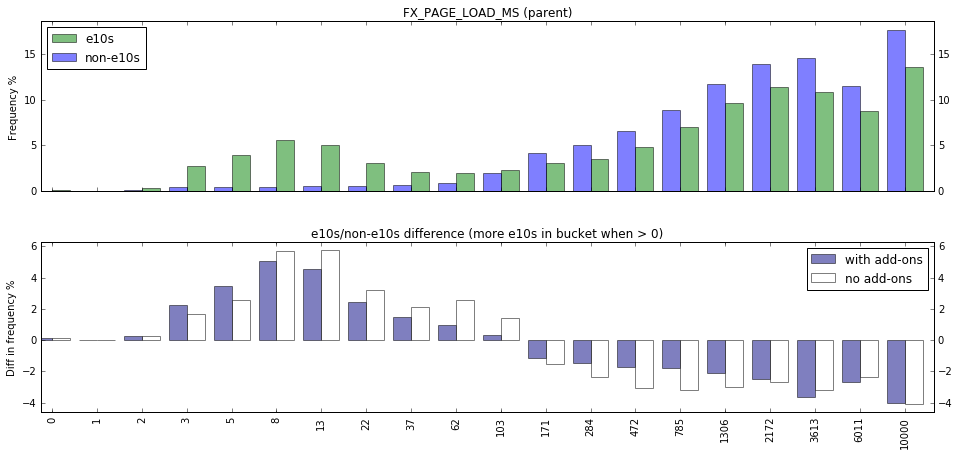

The probability that the distributions for FX_PAGE_LOAD_MS (parent) (with add-ons) are differing by chance is 0.00.


In [91]:
compare_histograms(subset, "payload/histograms/FX_PAGE_LOAD_MS")

## 1.5 Startup/shutdown time

In [60]:
simple = pd.DataFrame(get_pings_properties(subset, [
    "payload/simpleMeasurements/firstPaint",
    "payload/simpleMeasurements/sessionRestored",
    "payload/simpleMeasurements/shutdownDuration",
    "e10s",
    "addons"]).collect())

eSimple = simple[simple["addons"] & simple["e10s"]]
nSimple = simple[simple["addons"] & ~simple["e10s"]]
eSimple_std = simple[~simple["addons"] & simple["e10s"]]
nSimple_std = simple[~simple["addons"] & ~simple["e10s"]]

len(eSimple), len(nSimple), len(eSimple_std), len(nSimple_std)

(28746, 28639, 28647, 28607)

In [63]:
compare_scalars("firstPaint time",
                eSimple["payload/simpleMeasurements/firstPaint"],
                nSimple["payload/simpleMeasurements/firstPaint"],
                eSimple_std["payload/simpleMeasurements/firstPaint"],
                nSimple_std["payload/simpleMeasurements/firstPaint"],
                "ms")

Comparison for firstPaint time (ms) (with add-ons):

- Median with e10s is 60 ms higher than median without e10s.
- This is a relative difference of 1.4%.
- E10s group median is 4309, non-e10s group median is 4249.

The probability of this difference occurring purely by chance is 0.213.

For cohorts with no add-ons, median with e10s is 160 ms (4.0%) higher than median without


In [ ]:
compare_scalars("sessionRestored time",
                eSimple["payload/simpleMeasurements/sessionRestored"],
                nSimple["payload/simpleMeasurements/sessionRestored"],
                eSimple_std["payload/simpleMeasurements/sessionRestored"],
                nSimple_std["payload/simpleMeasurements/sessionRestored"],
               "ms")

In [ ]:
compare_scalars("shutdownDuration time",
                eSimple["payload/simpleMeasurements/shutdownDuration"],
                nSimple["payload/simpleMeasurements/shutdownDuration"],
                eSimple_std["payload/simpleMeasurements/shutdownDuration"],
                nSimple_std["payload/simpleMeasurements/shutdownDuration"],
               "ms")

## 1.6 Scrolling

In [ ]:
compare_histograms(subset, "payload/histograms/FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS")

## 1.7 Plugin jank

In [ ]:
compare_histograms(subset,
                   "payload/histograms/BLOCKED_ON_PLUGIN_MODULE_INIT_MS",
                   "payload/histograms/BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS",
                   "payload/histograms/BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS")

## 1.8 Memory usage

In [ ]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_TOTAL",
                   "payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS")

## 1.9 UI Smoothness

In [ ]:
compare_histograms(subset, "payload/histograms/FX_TAB_SWITCH_TOTAL_MS")

## 1.11 Slow Scripts

In [82]:
compare_count_histograms(subset, "payload/histograms/SLOW_SCRIPT_PAGE_COUNT")

Comparison for count histogram [SLOW_SCRIPT_PAGE_COUNT](https://dxr.mozilla.org/mozilla-central/search?q=SLOW_SCRIPT_PAGE_COUNT+file%3AHistograms.json&redirect=true) (with add-ons):

2015 (7.0%) non-e10s profiles have this histogram.
2314 (8.0%) e10s profiles have this histogram.

Comparison for SLOW_SCRIPT_PAGE_COUNT per hour (with add-ons):

- Median with e10s is -0.0406 units different from median without e10s.
- This is a relative difference of -11.7%.
- E10s group median is 0.3077, non-e10s group median is 0.3483.

The probability of this difference occurring purely by chance is 0.046.

For cohorts with no add-ons, median with e10s is -0.0707 units (-17.2%) different from median without


----------

# Previous metrics

## 1. Generic stuff

In [ ]:
simple = pd.DataFrame(get_pings_properties(subset, [
    "payload/simpleMeasurements/firstPaint",
    "payload/simpleMeasurements/firstLoadURI",
    "payload/simpleMeasurements/sessionRestored",
    "payload/simpleMeasurements/sessionRestoreInit",
    "payload/simpleMeasurements/shutdownDuration",
    "e10s",
    "parent_hangs_per_minute",
    "child_hangs_per_minute"]).collect())

eSimple = simple[simple["e10s"] == True]
nSimple = simple[simple["e10s"] == False]
len(eSimple), len(nSimple)

#### a) Startup time evaluation:

In [ ]:
compare_scalars("startup time", eSimple["payload/simpleMeasurements/firstPaint"].dropna(), nSimple["payload/simpleMeasurements/firstPaint"].dropna())

In [ ]:
compare_scalars("startup time", eSimple["payload/simpleMeasurements/firstLoadURI"].dropna(), nSimple["payload/simpleMeasurements/firstLoadURI"].dropna())

#### b) Shutdown time evaluation:

In [ ]:
compare_scalars("shutdown duration", eSimple["payload/simpleMeasurements/shutdownDuration"].dropna(), nSimple["payload/simpleMeasurements/shutdownDuration"].dropna())

#### c) Animation smoothness:

In [ ]:
compare_histograms(subset,
                   "payload/histograms/FX_TAB_ANIM_ANY_FRAME_INTERVAL_MS",
                   "payload/histograms/FX_TAB_ANIM_OPEN_FRAME_INTERVAL_MS",
                   "payload/histograms/FX_TAB_ANIM_OPEN_PREVIEW_FRAME_INTERVAL_MS")

#### d) Graphics:

In [ ]:
compare_histograms(subset, "payload/histograms/REFRESH_DRIVER_TICK",
                           "payload/histograms/FX_REFRESH_DRIVER_CHROME_FRAME_DELAY_MS")

## 2. Responsivness

#### a) Event processing

In [ ]:
compare_histograms(subset, "payload/histograms/EVENTLOOP_UI_ACTIVITY_EXP_MS",
                           "payload/histograms/INPUT_EVENT_RESPONSE_MS")

In [ ]:
compare_scalars("hangs over 100ms per minute (parent)",
                eSimple["parent_hangs_per_minute"].dropna(),
                nSimple["parent_hangs_per_minute"].dropna())

In [ ]:
compare_scalars("hangs over 100ms per minute (parent + child)",
                (eSimple["child_hangs_per_minute"] + eSimple["parent_hangs_per_minute"]).dropna(),
                nSimple["parent_hangs_per_minute"].dropna())

#### b) Plugins

In [ ]:
compare_count_histograms(subset, "payload/keyedHistograms/SUBPROCESS_ABNORMAL_ABORT/plugin")

#### c) Page load

In [ ]:
compare_histograms(subset, "payload/histograms/FX_PAGE_LOAD_MS")

#### d) Slow scripts

In [ ]:
compare_count_histograms(subset, "payload/histograms/SLOW_SCRIPT_NOTICE_COUNT")

In [ ]:
compare_count_histograms(subset, "payload/histograms/SLOW_SCRIPT_PAGE_COUNT")

#### e) Window open time

In [ ]:
compare_histograms(subset, "payload/histograms/FX_NEW_WINDOW_MS")

#### f) Garbage collection

In [ ]:
compare_histograms(subset, 
                   "payload/histograms/GC_MS", 
                   "payload/histograms/GC_MAX_PAUSE_MS", 
                   "payload/histograms/GC_MARK_MS", 
                   "payload/histograms/GC_SWEEP_MS", 
                   "payload/histograms/GC_MARK_ROOTS_MS")

In [ ]:
compare_histograms(subset,
                   "payload/histograms/GC_MMU_50",
                   "payload/histograms/GC_MARK_GRAY_MS",
                   "payload/histograms/GC_SLICE_MS",
                   "payload/histograms/GC_SCC_SWEEP_TOTAL_MS",
                   "payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS")

#### g) Cycle Collector

In [ ]:
compare_histograms(subset,
                   "payload/histograms/CYCLE_COLLECTOR",
                   "payload/histograms/CYCLE_COLLECTOR_WORKER",
                   "payload/histograms/CYCLE_COLLECTOR_FULL",
                   "payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE",
                   "payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN")

## 3. Memory

#### a) Usage (bytes)

In [ ]:
compare_histograms(subset,
                #   "payload/histograms/MEMORY_TOTAL",
                 #  "payload/histograms/MEMORY_VSIZE",
                  # "payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS",
                  # "payload/histograms/MEMORY_HEAP_ALLOCATED",
                   "payload/histograms/MEMORY_JS_GC_HEAP")

In [ ]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED",
                   "payload/histograms/MEMORY_STORAGE_SQLITE")

#### c) JS compartments

In [ ]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_JS_COMPARTMENTS_SYSTEM",
                   "payload/histograms/MEMORY_JS_COMPARTMENTS_USER")

#### d) Low memory events

In [ ]:
compare_histograms(subset,
                   "payload/histograms/LOW_MEMORY_EVENTS_VIRTUAL",
                   "payload/histograms/LOW_MEMORY_EVENTS_PHYSICAL")

#### e) Page faults

In [ ]:
compare_histograms(subset,
                   "payload/histograms/PAGE_FAULTS_HARD")

#### f) Ghost windows

In [ ]:
compare_histograms(subset,
                   "payload/histograms/GHOST_WINDOWS")

## 3. Other

Differences discovered by comparing all histograms (see Bug [1198638](https://bugzilla.mozilla.org/show_bug.cgi?id=1198638))

In [ ]:
compare_histograms(subset,
                   "payload/histograms/STARTUP_HTTP_CACHE_DISPOSITION_2_V2",
                   "payload/histograms/STARTUP_NETWORK_CACHE_METADATA_FIRST_READ_TIME_MS",
                   "payload/histograms/STARTUP_NETWORK_CACHE_V2_HIT_TIME_MS")

In [ ]:
compare_histograms(subset,
                   "payload/histograms/HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2",
                   "payload/histograms/HTTP_PAGE_COMPLETE_LOAD_CACHED_V2",
                   "payload/histograms/HTTP_PAGE_COMPLETE_LOAD",
                   "payload/histograms/HTTP_SUB_COMPLETE_LOAD_CACHED_V2",
                   "payload/histograms/HTTP_SUB_COMPLETE_LOAD",                   
                   "payload/histograms/HTTP_SUB_REVALIDATION",
                   "payload/histograms/HTTP_SUB_OPEN_TO_FIRST_FROM_CACHE_V2")

In [ ]:
compare_histograms(subset, 
                   "payload/histograms/FX_THUMBNAILS_CAPTURE_TIME_MS",                   
                   "payload/histograms/LOCALDOMSTORAGE_GETVALUE_BLOCKING_MS",
                   "payload/histograms/FX_SESSION_RESTORE_RESTORE_WINDOW_MS",
                   "payload/histograms/FX_SESSION_RESTORE_STARTUP_ONLOAD_INITIAL_WINDOW_MS")

In [ ]:
compare_histograms(subset, 
                   "payload/histograms/IMAGE_DECODE_ON_DRAW_LATENCY",
                   "payload/histograms/IMAGE_DECODE_SPEED_GIF",
                   "payload/histograms/AUDIOSTREAM_LATER_OPEN_MS",
                   "payload/histograms/AUDIOSTREAM_FIRST_OPEN_MS")

In [ ]:
compare_histograms(subset, 
                   "payload/histograms/MEMORY_STORAGE_SQLITE",
                   "payload/histograms/BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS")

In [ ]:
IPython.core.pylabtools.figsize(32, 7)
compare_histograms(subset, 
                   "payload/histograms/CERT_VALIDATION_HTTP_REQUEST_CANCELED_TIME",
                   "payload/histograms/STARTUP_NETWORK_CACHE_METADATA_SIZE",
                   "payload/histograms/STARTUP_NETWORK_CACHE_METADATA_FIRST_READ_SIZE")
IPython.core.pylabtools.figsize(16, 7)

**bug 1226564** - please compare `HTTP_*_COMPLETE_LOAD_NET_V2`

In [ ]:
compare_histograms(subset,
                   "payload/histograms/HTTP_PAGE_COMPLETE_LOAD_NET_V2",
                   "payload/histograms/HTTP_SUB_COMPLETE_LOAD_NET_V2")

**bug 1255159** - Please look at FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS

In [ ]:
compare_histograms(subset, "payload/histograms/FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS")

**bug 1273847** - Please look at SLOW_SCRIPT_NOTIFY_DELAY, SHUTDOWN_OK

In [ ]:
compare_histograms(subset, "payload/histograms/SLOW_SCRIPT_NOTIFY_DELAY")

In [ ]:
compare_histograms(subset, "payload/histograms/SHUTDOWN_OK")